In [1]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import r2_score
import dask_ml
import dask
import pandas as pd
import numpy as np
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*Sending large graph.*")

from dask.distributed import Client, LocalCluster
import dask.multiprocessing

cluster = LocalCluster(processes=True,n_workers=6, threads_per_worker=1)
client = Client(cluster)
import sys
import pickle 

from data_helpers import *
from metrics import *

In [ ]:
cluster = LocalCluster(processes=True,n_workers=6, threads_per_worker=1)
client = Client(cluster)

In [12]:
folders = [
    'train0_25',
    'train25_50',
    'train50_75',
    'train75_100'
]

# Read Parquet files from each folder into Dask DataFrames
dfs = [dd.read_parquet(folder) for folder in folders]

# Concatenate all DataFrames into a single DataFrame
data = dd.concat(dfs)

In [ ]:
ptend_q002 = []
for i in range(60):
    ptend_q002.append('ptend_q0002_'+str(i))

targetsToDrop12 = [ 'ptend_q0001', 'ptend_q0002', 'ptend_q0003', 'ptend_u', 'ptend_v']
dropT = [] #'ptend_q0002_12','ptend_q0002_13','ptend_q0002_14'] # attention, I think i also need to predict _15
for f in targetsToDrop12:
    dropT = dropT + [f+'_'+str(i) for i in range(12)]

allT2 = [i for i in allT if i not in dropT]

# mean & stddev computation

In [ ]:
meanDict ={}
for f in allT:
    meanDict[f] = data[f].mean().compute()

with open('meanDict_allT.pkl', 'wb') as f:
    pickle.dump(meanDict, f)    

In [ ]:
stdDict ={}
for f in allT:
    stdDict[f] = data[f].std().compute()

with open('stdDict_allT.pkl', 'wb') as f:
    pickle.dump(stdDict, f)  

In [ ]:
maxDict ={}
for f in allT:
    maxDict[f] = abs(data[f]).max().compute()

with open('maxDict_allT.pkl', 'wb') as f:
    pickle.dump(maxDict, f)  

In [6]:
with open('meanDict_allT.pkl', 'rb') as f:
    meanDict = pickle.load(f)

with open('stdDict_allT.pkl', 'rb') as f:
    stdDict = pickle.load(f)

# transform df

In [ ]:
def calculate_squared_error(row, mean_values,std_values, columns):
    return sum(((row[col] - mean_values[col])/std_values[col]) ** 2 for col in columns)

In [ ]:
squared_error_per_row = data.apply(lambda row: calculate_squared_error(row, meanDict, stdDict, allT2), axis=1, meta=('x', 'f8'))

# Compute the result
result = squared_error_per_row.compute()

In [ ]:
result.to_csv('sumSquaredError.csv')

In [ ]:
result = pd.read_csv('sumSquaredError.csv')

In [ ]:
normRes = result['0']/max(result['0'])

In [ ]:
normRes = normRes.reset_index()#.drop('index',axis=1)

In [ ]:
normRes.loc[normRes[0] > 0.0001]

In [ ]:
#data = data.assign(norm_weight = normRes[0].values)
dask_series = dd.from_pandas(normRes, npartitions=data.npartitions)#,chunks=data.npartitions)

In [ ]:
import dask.array as da

dask_array = da.from_array(normRes[0], chunks=data.partitions[0].shape[0].compute())

## by assign function

In [ ]:
min(normRes), max(result)

In [ ]:
data1 = data.assign(weight=data.apply(lambda row: calculate_squared_error(row, meanDict, stdDict, allT2), axis=1, meta=('x', 'f8')))
data1['normWeight'] = data1['weight'] / max(result['0'])

In [ ]:
largeSamp = data1.loc[(data1['normWeight'] > 0.0001)] 

In [ ]:
largeSamp = largeSamp.compute()

## add new index

In [ ]:
normRes

In [ ]:
new_index = dd.from_pandas(normRes, npartitions=data.npartitions)

In [ ]:
data = data.assign(new_index=new_index)

In [ ]:
data = data.set_index('new_index', sorted=True)

# transform df per partition and write it to source

In [10]:
def calculate_squared_error(row, mean_values,std_values, columns):
    return sum(((row[col] - mean_values[col])/std_values[col]) ** 2 for col in columns)

In [ ]:
folders = [
    #'testPar',
    'train0_25',
    'train25_50',
    'train50_75',
    'train75_100'
]

def calculate_squared_errorPart(partition, mean_values, std_values, columns):
    #return sum(((row[col] - mean_values[col])/std_values[col]) ** 2 for col in columns)
    partition['weight'] = partition.apply(lambda row : calculate_squared_error(row, mean_values, std_values, columns),axis=1)
    #partition['weight'] = 1
    return partition

for folder in folders:
    data = dd.read_parquet(folder)

    data = data.map_partitions(
        calculate_squared_errorPart,
        mean_values=meanDict,
        std_values=stdDict,
        columns=allT2,
        #meta=('squared_error', 'float64')
        )
    
    data.to_parquet(folder)



In [ ]:
maxVal = data['weight'].max().compute()

In [ ]:
folders = [
    'testPar',
    'train0_25',
    'train25_50',
    'train50_75',
    'train75_100'
]

def calculate_norm_weight(partition, maxVal):
    #return sum(((row[col] - mean_values[col])/std_values[col]) ** 2 for col in columns)
    partition['norm_weight'] = partition['weight'] / maxVal
    #partition['weight'] = 1
    return partition


for folder in folders:
    data = dd.read_parquet(folder)

    data = data.map_partitions(
        calculate_norm_weight,
        maxVal = maxVal
        )
    
    data.to_parquet(folder)



In [11]:
folders = [
    #'testPar',
    'train0_25',
    'train25_50',
    'train50_75',
    'train75_100'
]

def calculate_squared_errorPart(partition, mean_values, std_values, columns):
    #return sum(((row[col] - mean_values[col])/std_values[col]) ** 2 for col in columns)
    partition['weight_ptend_q0002_26'] = partition.apply(lambda row : calculate_squared_error(row, mean_values, std_values, columns),axis=1)
    #partition['weight'] = 1
    return partition

for folder in folders:
    data = dd.read_parquet(folder)

    data = data.map_partitions(
        calculate_squared_errorPart,
        mean_values=meanDict,
        std_values=stdDict,
        columns=['ptend_q0002_26'],
        #meta=('squared_error', 'float64')
        )
    
    data.to_parquet(folder)



# get large values per feature

In [ ]:
separator=10
condition = None
subF = []
for i in range(20,27):
    f = 'ptend_q0002_' + str(i)
    subF.append(f)
    if condition is None:
        condition = (abs(data[f]) > separator*abs(meanDict[f]))
    else:
        condition = condition | (abs(data[f]) > separator*abs(meanDict[f]))

In [ ]:
tr_large = data.loc[condition]
tr_large = tr_large.compute()
# 5.5 min for sep1

In [ ]:
a=1
trShape = tr_large.shape[0]
for f in subF:
    count26 = tr_large.loc[abs(tr_large[f]) > a*abs(meanDict[f])].shape[0]
    print(f, count26, round(count26/trShape, 2)*100)

In [ ]:
tr_large.loc[(abs(tr_large['ptend_q0002_26']) > separator*abs(meanDict['ptend_q0002_26'])) | (abs(tr_large['ptend_q0002_25']) > separator*abs(meanDict['ptend_q0002_25']))]

In [ ]:
separator=3
tr_large_25 = data.loc[(abs(data['ptend_q0002_25']) > separator*abs(meanDict['ptend_q0002_25']))]
tr_large_25 = tr_large_25.compute()

In [ ]:
separator=3
tr_large_27 = data.loc[(abs(data['ptend_q0002_27']) > separator*abs(meanDict['ptend_q0002_27']))]
tr_large_27 = tr_large_27.compute()

In [ ]:
plt.scatter(x=range(tr_large.shape[0]),y=tr_large['ptend_q0002_26'], s=1,label='ptend_q0002_26')
plt.scatter(x=range(tr_large.shape[0]),y=tr_large['ptend_q0002_25'], s=1,label='ptend_q0002_25')
plt.scatter(x=range(tr_large.shape[0]),y=tr_large['ptend_q0002_24'], s=1,label='ptend_q0002_24')
plt.scatter(x=range(tr_large.shape[0]),y=tr_large['ptend_q0002_27'], s=1,label='ptend_q0002_27')
plt.legend()
plt.show()

# analyze norm weight

In [ ]:
folders_tr = [
    'train0_25',
    'train25_50',
    'train50_75',
]
folders_te = [
    'train75_100'
]

dfs = [dd.read_parquet(folder) for folder in folders_tr]
train = dd.concat(dfs)

dfs = [dd.read_parquet(folder) for folder in folders_te]
test = dd.concat(dfs)

In [ ]:
large_tr = train.loc[train['norm_weight'] > 0.0001].compute()
# 0.001 ~6min, 1250 samples
# 0.0005 ~8.5min, 4166 samples (min weight = 13126)
# 0.0001 ~11.5min, 90485 (min weight 2625) -> too many unimportant samples I guess

In [ ]:
large_tr.to_parquet('large_training_df_0001')

In [ ]:
# get 100k small samples
small_sample_size = train.shape[0].compute()
small_tr = train.sample(frac=100000/small_sample_size).compute()

In [ ]:
small_tr.to_parquet('small_training_df_0001')

# analyze large values per feature

In [7]:
f = 'ptend_q0002_26'
large_tr = data.loc[abs(data[f]) > abs(meanDict[f])].compute()

In [8]:
large_tr.to_csv('large_ptend_q0002_26.csv')

In [15]:
data.weight_ptend_q0002_26.max().compute()

9322381.95034371

2024-07-02 08:55:41,460 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:49429 -> tcp://127.0.0.1:49417
Traceback (most recent call last):
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/tornado/iostream.py", line 962, in _handle_write
    num_bytes = self.write_to_fd(self._write_buffer.peek(size))
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/tornado/iostream.py", line 1124, in write_to_fd
    return self.socket.send(data)  # type: ignore
OSError: [Errno 55] No buffer space available

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/distributed/worker.py", line 1783, in get_data
    response = await comm.read(deserializers=serializers)
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/distributed/comm/tcp.py", line 236, in read
    convert

<Axes: >

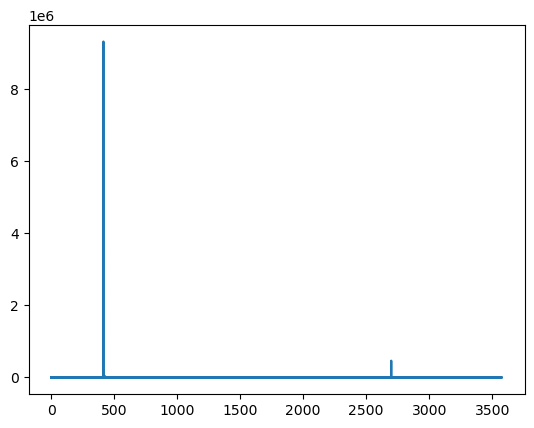

In [17]:
data.weight_ptend_q0002_26.compute().plot()

In [18]:
weighgs=data.weight_ptend_q0002_26.compute()

2024-07-02 09:03:01,395 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:49418 -> tcp://127.0.0.1:49419
Traceback (most recent call last):
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/tornado/iostream.py", line 962, in _handle_write
    num_bytes = self.write_to_fd(self._write_buffer.peek(size))
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/tornado/iostream.py", line 1124, in write_to_fd
    return self.socket.send(data)  # type: ignore
OSError: [Errno 55] No buffer space available

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/distributed/worker.py", line 1783, in get_data
    response = await comm.read(deserializers=serializers)
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/distributed/comm/tcp.py", line 236, in read
    convert

In [23]:
np.sort(weighgs)[-20:-1]

array([3.00361029e+00, 1.31940788e+01, 2.20803153e+01, 7.08946422e+01,
       9.29669019e+01, 2.28740412e+02, 2.37511352e+02, 2.91140111e+02,
       5.72682107e+02, 1.00928723e+03, 3.13025223e+03, 4.32181508e+03,
       4.52985582e+03, 5.90548817e+03, 3.45585893e+04, 6.92163560e+04,
       7.02532766e+04, 1.08038709e+05, 4.66634471e+05])